In [10]:
#####################################################
## This code cell must be executed once before the ##
## others. It defines all the necessary functions. ##
#####################################################

import os
import json
import numpy as np
import scipy.io
from IPython.display import Audio, HTML
import struct
from io import BytesIO
import wave

# Default sampling rate:
samplingrate = 48000

def db2amp(d):
    return 10 ** (float(d) / 20)
def amp2db(f):
    return 20 * np.log10(f)

def us2s(microseconds):
    return microseconds * 1e-6
def s2us(seconds):
    return seconds * 1e6

def ms2s(m_seconds):
    return m_seconds * 1e-3
def s2ms(seconds):
    return seconds * 1e3

def times(signal):
    if isinstance(signal, (tuple, list)):
        signal = signal[0]
    return np.arange(signal.size)/samplingrate

def signal_energy(signal, fs=100e3):
    #signal = signal.astype(np.float64)
    #print np.min(signal), np.max(signal)
    return np.sum(signal.astype(np.float64) ** 2) / fs

def signal_power(signal, fs=100e3):
    return signal_energy(signal, fs=fs) / signal.size

def band_limits(center=8500, octave_width=1.0):
    return float(center) * 2**(-.5*octave_width), float(center) * 2**(+.5*octave_width)

def to_stereo(signal):
    """Return a tuple of left and right signal
    A single signal will be duplicated.
    A stereo signal will be returned unchanged.
    """
    try:
        signal_L, signal_R = signal
        #print "Play: Stereo"
    except ValueError:
        signal_L = signal
        signal_R = signal
        #print "Play: Mono"
    return (signal_L, signal_R)

def ramp(x = None, start = 0.0, stop = 1.0, ramp_dur = .05, fs = None, amp = 1.0):
    """ramp(x = np.ones(fs), start = .400, stop = .500, ramp_dur = .05, fs = fs, amp = 1.0)
    
    Ramp the signal x by linaer ramps between start and stop
    
    Examples
    ========
    
    >>> ramp()
    returns the default ramp function as it generates internally data x as all ones for 1 s with fs.
    """
    if fs is None:
        fs = samplingrate
    if x is None:
        x = np.ones(int(fs))
    t1 = start
    t2 = (start + ramp_dur)
    t3 = (stop - ramp_dur)
    t4 = stop
    t = np.arange(x.size) / fs
    r = amp * np.piecewise(t, [(t1 <= t) & (t < t2), (t2 <= t) & (t < t3), (t3 <= t) & (t < t4)],
                         [lambda t: (t - t1) / (t2-t1), 1, lambda t: 1 - (t - t3) / (t4-t3), 0])
    return r * x

def bandpass_itd_noise(min_freq = 20, max_freq = 20000, itd=0, fs=None, samples = None):
    """bandpass_itd_noise()
    """
    # Calculate available fft frequencies:
    if fs is None:
        fs = samplingrate
    if samples is None:
        samples = int(fs)
    freqs = np.fft.rfftfreq(samples, 1/fs)
    f = np.zeros_like(freqs)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1 * np.sqrt(.5 * samples) * (f.size / np.count_nonzero(idx))**.5
    f = np.array(f, dtype='complex')

    phases_rad = np.random.rand(len(f)) * 2 * np.pi
    phases = np.cos(phases_rad) + 1j * np.sin(phases_rad)

    itd_phas_rad = us2s(itd) * np.pi * freqs #  * .5 * 2
    shift_left = np.cos(-itd_phas_rad) + 1j * np.sin(-itd_phas_rad)
    shift_right = np.cos(+itd_phas_rad) + 1j * np.sin(+itd_phas_rad)
    phases_left = phases * shift_left
    phases_right = phases * shift_right

    f_left = f * phases_left
    f_right = f * phases_right

    s_left = np.fft.irfft(f_left).real
    s_right = np.fft.irfft(f_right).real
    return s_left, s_right

def bandpass_mono_noise(min_freq = 20, max_freq = 20000, fs=None, samples = None):
    """bandpass_mono_noise(min_freq = 20, max_freq = 20000, fs=None, samples = None)
    """
    # Calculate available fft frequencies:
    if fs is None:
        fs = samplingrate
    if samples is None:
        samples = int(fs)
    freqs = np.fft.rfftfreq(samples, 1.0/fs)
    f = np.zeros_like(freqs)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1 * np.sqrt(samples)
    f = np.array(f, dtype='complex')

    phases_rad = np.random.rand(len(f)) * 2 * np.pi
    phases = np.cos(phases_rad) + 1j * np.sin(phases_rad)

    f_mono = f * phases

    s_mono = np.fft.irfft(f_mono).real
    return s_mono

def do_ild(signal, ild = 0):
    signal_L, signal_R = to_stereo(signal)
    amp_L = db2amp(-.5 * ild)
    amp_R = db2amp(+.5 * ild)
    return amp_L * signal_L, amp_R * signal_R

def do_bc(signal, bc = 100, **noise_kwargs):
    signal_L, signal_R = to_stereo(signal)
    if bc != 100:
        if bc < 0:
            signal_R = -signal_R
        r = abs(bc / 100)
        _, decorr_noise_L = bandpass_itd_noise(itd=0, **noise_kwargs)
        _, decorr_noise_R = bandpass_itd_noise(itd=0, **noise_kwargs)
        # Adjust powers:
        decorr_noise_L = decorr_noise_L / (signal_power(decorr_noise_L) / signal_power(signal_L))**.5
        decorr_noise_R = decorr_noise_R / (signal_power(decorr_noise_R) / signal_power(signal_R))**.5
        signal_L = r**.5 * signal_L + (1 - r)**.5 * decorr_noise_L
        signal_R = r**.5 * signal_R + (1 - r)**.5 * decorr_noise_R
    return signal_L, signal_R

def stack(*signals):
    n = len(signals)
    signal_stack = tuple(np.sum(np.stack([s[c] for s in signals]), axis=0) / np.sqrt(n) for c in (0, 1))
    return signal_stack

def pscale(signal, rel_power=1.0):
    scaled_signal = tuple(signal[c] * np.sqrt(rel_power) for c in (0, 1))
    return scaled_signal

def player(signal, rel_abi=0, samplingrate = samplingrate):
    # Make it stereo and stack in one 
    signal = np.vstack(to_stereo(signal))
    scaled = signal.T.ravel() * 1024 * db2amp(rel_abi)
    if np.max(np.abs(scaled)) > 32767:
        scale_by = 32767 / np.max(np.abs(scaled))
        scaled = scaled * scale_by
        import sys
        print(f"Signal would have clipped. Scaled (down) by {amp2db(scale_by):.1g} dB.", file=sys.stderr)
    fp = BytesIO()
    waveobj = wave.open(fp,mode='wb')
    waveobj.setnchannels(2)
    waveobj.setframerate(samplingrate)
    waveobj.setsampwidth(2)
    waveobj.setcomptype('NONE','NONE')
    waveobj.writeframes(b''.join([struct.pack('<h',x) for x in np.int16(scaled)]))
    pmc_data = fp.getvalue()
    waveobj.close()
    display(Audio(pmc_data, rate=samplingrate, autoplay=False))

def save_wave(signal, filename, rel_abi=0, samplingrate=samplingrate):
    # Make it stereo and stack in one 
    signal = np.vstack(to_stereo(signal))
    scaled = signal.T.ravel() * 1024 * db2amp(rel_abi)
    if np.max(np.abs(scaled)) > 32767:
        scale_by = 32767 / np.max(np.abs(scaled))
        scaled = scaled * scale_by
        import sys
        print(f"Signal would have clipped. Scaled (down) by {amp2db(scale_by):.1g} dB.", file=sys.stderr)
    with open(filename, 'wb') as fp:
        waveobj = wave.open(fp,mode='wb')
        waveobj.setnchannels(2)
        waveobj.setframerate(samplingrate)
        waveobj.setsampwidth(2)
        waveobj.setcomptype('NONE','NONE')
        waveobj.writeframes(b''.join([struct.pack('<h',x) for x in np.int16(scaled)]))
        waveobj.close()

def noise(min_freq = 20, max_freq = 20000, itd=0, ild=0, bc=100, length=1.0, level=0, ramp_dur=0.05, pad_length=0.005, show_player=True, return_signal=False):
    samples = int((length + 2 * pad_length) * samplingrate)
    signal_LR = bandpass_itd_noise(min_freq, max_freq, itd, samplingrate, samples)
    signal_LR = do_bc(signal_LR, bc=bc, min_freq=min_freq, max_freq=max_freq, fs=samplingrate, samples=samples)
    signal_LR = do_ild(signal_LR, ild)
    signal_LR = [ramp(s, start=pad_length, stop=length+pad_length, ramp_dur=ramp_dur) for s in signal_LR]
    if show_player:
        display(HTML(f'<p><strong>Noise</strong> {min_freq}-{max_freq} Hz, '
                     f'ITD = {itd} μs, ILD = {ild} dB, BC = {bc}%'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR, rel_abi=level)
    if return_signal:
        return signal_LR

def tone(freq = 440, itd=0, ild=0, bc=100, length=1.0, level=0, ramp_dur=0.05, pad_length=0.005, show_player=True, return_signal=False, **bc_noise_kwargs):
    samples = int((length + 2 * pad_length) * samplingrate)
    t = np.arange(0, samples) / samplingrate
    phase = np.random.rand(1) * 2 * np.pi
    shift = us2s(itd) * np.pi * freq
    signal_LR = (
        np.sin(t * 2 * np.pi * freq + phase - shift),
        np.sin(t * 2 * np.pi * freq + phase + shift)
    )
    signal_LR = do_bc(signal_LR, bc=bc, fs=samplingrate, samples=samples, **bc_noise_kwargs)
    signal_LR = do_ild(signal_LR, ild)
    signal_LR = [ramp(s, start=pad_length, stop=length+pad_length, ramp_dur=ramp_dur) for s in signal_LR]
    if show_player:
        display(HTML(f'<p><strong>Tone</strong> {freq} Hz, '
                     f'ITD = {itd} μs, ILD = {ild} dB, BC = {bc}%'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR, rel_abi=level)
    if return_signal:
        return signal_LR

def tone_stack(freqs = np.arange(500, 12000, 1000), show_player=True, return_signal=False, show_single_player=False, **tone_kwargs):
    tone_kwargs.update(show_player=show_single_player)
    tone_kwargs.update(return_signal=True)
    signal_LR = stack(*[tone(freq=f, **tone_kwargs) for f in freqs])
    if show_player:
        display(HTML(f'<p><strong>Tone-Stack</strong> {freqs} Hz, '
                     f'ITD = {tone_kwargs.get("itd",0)} μs, ILD = {tone_kwargs.get("ild",0)} dB, BC = {tone_kwargs.get("bc",100)}%'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR)
    if return_signal:
        return signal_LR



In [11]:
savedir = os.getcwd()

## ITD

In [ ]:
d = {}
for itd in np.linspace(-900, 900, 13, dtype='int'):
#     print(itd)
    s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'noise_itd/itd{itd:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath)
    d[str(itd)] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

## ILD

In [ ]:
d = {}
for ild in np.linspace(-30, 30, 13, dtype='int'):
    s = noise(ild=ild, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'noise_ild/ild{ild:+03d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath)
    d[str(ild)] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

## Frequency and ITD

In [ ]:
d = {}
for freq in [100, 150, 200, 400, 600, 800, 1000, 1200, 2000, 5000, 9000]:
    d[str(freq)] = {}
    for itd in np.linspace(-900, 900, 13, dtype='int'):
    #     print(itd)
        s = tone(itd=itd, freq=freq, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
        savename = f'freq_itd/freq{freq:04d}_itd{itd:+04d}.wav'
        savepath = os.path.join(savedir, savename)
        if not os.path.exists(os.path.dirname(savepath)):
            os.mkdir(os.path.dirname(savepath))
        save_wave(s, savepath)
        d[str(freq)][str(itd)] = savename
print('"sounds": ', json.dumps(d, indent=4), ',', sep='')
print('-' * 79)
print(json.dumps({k: str(k) for k in d.keys()}, indent = 4))
print('-' * 79)
for k in d.keys():
    print(f'            <option value="{k}">{k}</option>')

## Frequency and ILD

In [ ]:
d = {}
for freq in [100, 150, 200, 400, 600, 800, 1000, 1200, 2000, 5000, 9000]:
    d[str(freq)] = {}
    for ild in np.linspace(-30, 30, 13, dtype='int'):
    #     print(itd)
        s = tone(ild=ild, freq=freq, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
        savename = f'freq_ild/freq{freq:04d}_ild{ild:+03d}.wav'
        savepath = os.path.join(savedir, savename)
        if not os.path.exists(os.path.dirname(savepath)):
            os.mkdir(os.path.dirname(savepath))
        save_wave(s, savepath)
        d[str(freq)][str(ild)] = savename
print('"sounds": ', json.dumps(d, indent=4), ',', sep='')
print('-' * 79)
print(json.dumps({k: str(k) for k in d.keys()}, indent = 4))
print('-' * 79)
for k in d.keys():
    print(f'            <option value="{k}">{k}</option>')

## ITD and Bandwidth

In [ ]:
d = {}
d_txt = {'bw': {}}
cf = 500
bws = [0, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900]
itds = [1500, -1500]
for itd in itds:
    d[str(itd)] = {}
    for kbw, bw in enumerate(bws):
    #     print(kbw, bw)
        if bw == 0:
            s = tone(itd=itd, freq=cf, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
        else:
            s = noise(itd=itd, min_freq=int(cf - bw/2), max_freq=int(cf + bw/2), length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
        savename = f'bw_itd/bw{bw:03d}_itd{itd:+04d}.wav'
        savepath = os.path.join(savedir, savename)
        if not os.path.exists(os.path.dirname(savepath)):
            os.mkdir(os.path.dirname(savepath))
        save_wave(s, savepath)
        d[str(itd)][str(kbw)] = savename
        d_txt['bw'][str(kbw)] = str(bw) if bw > 0 else "Tone"
    
d_sliders = {
    'bw': {
        '_title': "Bandwidth",
        "min": 0,
        "max": len(bws) - 1,
        "step": 1,
        "value": 0,
    }
}
d_selections = {
    'itd': {
        "_title": "ITD",
        "1500": "1500 (far right)",
        "-1500": "-1500 (far left)",
    }
}

dd = {"title": "Bandwidth & ITD", "sounds": d, "value_text": d_txt, "sliders": d_sliders, "selections": d_selections}
print('"bw_itd": ', json.dumps(dd, indent=4), ',', sep='')

## ILD vs ITD (time-intensity tradeoff)

In [ ]:
d = {}
itds = [300, 0, -300]
ilds_by_itd = {
    0: np.linspace(-10, 10, 5, dtype='int'),
    -300: np.linspace(0, 10, 11, dtype='int'),
    300: np.linspace(-10, 0, 11, dtype='int'),
}
for itd in itds:
    d[str(itd)] = {}
    for ild in ilds_by_itd[itd]:
        s = noise(itd=itd, ild=ild, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
        savename = f'itd_ild/itd{itd:+04d}_ild{ild:+03d}.wav'
        savepath = os.path.join(savedir, savename)
        if not os.path.exists(os.path.dirname(savepath)):
            os.mkdir(os.path.dirname(savepath))
        save_wave(s, savepath)
        d[str(itd)][str(ild)] = savename
    
d_sliders = {
    'ild': {
        '_title': "ILD",
        "min": -15,
        "max": 15,
        "step": 1,
        "value": 0,
    }
}
d_selections = {
    'itd': {
        "_title": "ITD",
        "_value": 0,
        "300": "300 (right)",
        "0": "0 (center)",
        "-300": "-300 (left)",
        "_sliders_update": {
            "-300": {
                "ild": {
                    "min": 0,
                    "max": 10,
                    "step": 1,
                    "value": 0
                }
            },
            "300": {
                "ild": {
                    "min": -10,
                    "max": 0,
                    "step": 1,
                    "value": 0
                }
            },
            "0": {
                "ild": {
                    "min": -10,
                    "max": 10,
                    "step": 5,
                    "value": 0
                }
            },
        }
    }
}

dd = {"title": "Time-intensity trade", "sounds": d, "sliders": d_sliders, "selections": d_selections}
print('"itd_ild": ', json.dumps(dd, indent=4), ',', sep='')

## Virtual Stimuli (HRTF-filtered)

In [83]:
class HRIR_provider():
    
    instance = None

    @classmethod
    def get_instance(cls):
        if cls.instance is None:
            cls.instance = cls()
        return cls.instance

    def __init__(self, subject = 58):
        self.__class__.instance = self
        self.subject = int(subject)
        ma_dict = scipy.io.loadmat(r"./hrtf_files/subject_{:03d}/hrir_final.mat".format(self.subject))
        #set possible azimuth/elevation angles
        self.azimuths = np.array([-80, -65, -55] + list(range(-45,45,5)) + [45, 55, 65, 80])
        self.elevations = np.arange(0,50) * 5.625 - 45.0
        self.L = dict()
        self.R = dict()
        #create a dictionary entry for every azi and ele combination 
        for naz in range(len(self.azimuths)):
            for nel in range(len(self.elevations)):
                self.L[(self.azimuths[naz], self.elevations[nel])] = ma_dict['hrir_l'][naz, nel, :]
                self.R[(self.azimuths[naz], self.elevations[nel])] = ma_dict['hrir_r'][naz, nel, :]

def hrtf_noise(min_freq = 20, max_freq = 20000, azi=0, ele=0, length=1.0, level=0, ramp_dur=0.05, pad_length=0.005, hrir_samplingrate = 44100, show_player=True, return_signal=False):
    hrirs = HRIR_provider.get_instance()
    samples = int((length + 2 * pad_length) * samplingrate)
    signal_M = bandpass_mono_noise(min_freq=min_freq, max_freq=max_freq, fs = hrir_samplingrate, samples=samples)
    signal_M = ramp(signal_M, start=pad_length, stop=length+pad_length, ramp_dur=ramp_dur, fs=hrir_samplingrate)
    signal_LR = np.vstack((
        np.convolve(hrirs.L[azi, ele], signal_M),
        np.convolve(hrirs.R[azi, ele], signal_M),
    ))
    if show_player:
        display(HTML(f'<p><strong>Noise</strong> {min_freq}-{max_freq} Hz, '
                     f'AZI = {azi}°, ELE = {ele}° (CIPIC coordinates)'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR, rel_abi=level)
    if return_signal:
        return signal_LR

def hrtf_tone(freq = 440, azi=0, ele=0, length=1.0, level=0, ramp_dur=0.05, pad_length=0.005, hrir_samplingrate = 44100, show_player=True, return_signal=False):
    hrirs = HRIR_provider.get_instance()
    samples = int((length + 2 * pad_length) * hrir_samplingrate)
    t = np.arange(0, samples) / hrir_samplingrate
    phase = np.random.rand(1) * 2 * np.pi
    signal_M = np.sin(t * 2 * np.pi * freq + phase)
    signal_M = ramp(signal_M, start=pad_length, stop=length+pad_length, ramp_dur=ramp_dur, fs=hrir_samplingrate)
    signal_LR = np.vstack((
        np.convolve(hrirs.L[azi, ele], signal_M),
        np.convolve(hrirs.R[azi, ele], signal_M),
    ))
    if show_player:
        display(HTML(f'<p><strong>Tone</strong> {freq} Hz, '
                     f'AZI = {azi}°, ELE = {ele}° (CIPIC coordinates)'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR, rel_abi=level)
    if return_signal:
        return signal_LR

def hrtf_natural(file, azi=0, ele=0, length=None, level=0, ramp_dur=0.05, pad_length=0.005, hrir_samplingrate = 44100, channel=0, show_player=True, return_signal=False):
    hrirs = HRIR_provider.get_instance()
    wavrate, signal_M = scipy.io.wavfile.read(file)
    if signal_M.ndim > 1:
        signal_M = signal_M[:,channel]
    if length is None:
        length = (signal_M.size-1) / wavrate
    samples = int((length + 2 * pad_length) * hrir_samplingrate)
    if not wavrate == hrir_samplingrate:
        raise ValueError("Sampling rates don't match; wav file {wavrate} Hz vs. hrir {hrir_samplingrate} Hz")
    signal_M = ramp(signal_M, start=pad_length, stop=length+pad_length, ramp_dur=ramp_dur, fs=hrir_samplingrate)
    signal_LR = np.vstack((
        np.convolve(hrirs.L[azi, ele], signal_M),
        np.convolve(hrirs.R[azi, ele], signal_M),
    ))
    if show_player:
        display(HTML(f'<p><strong>Natural sound</strong> "{os.path.basename(file)}", '
                     f'AZI = {azi}°, ELE = {ele}° (CIPIC coordinates)'
                     '</p><style type="text/css">audio {min-width: 400px; }</style>'))
        player(signal_LR, rel_abi=level)
    if return_signal:
        return signal_LR

In [98]:
hrtf_natural('./sound_snippets/baby-laughing.wav', azi=80, length=None, pad_length=.02, return_signal=True)

Signal would have clipped. Scaled (down) by -6e+01 dB.


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.30442465e-04, -8.60886920e-05, -3.35113871e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.68029921e-05, -5.27326777e-06,  1.19006453e-05]])

### HTRF Noise

In [12]:
d = {}
for azi, ele in [(-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180), (0,180)]:
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_noise(min_freq=60, max_freq=10000, azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'noise_hrtf/azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=44100)
    d[str(show_azi)] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

var sounds = {
    "-140": "noise_hrtf/azi-140.wav",
    "-80": "noise_hrtf/azi-080.wav",
    "-40": "noise_hrtf/azi-040.wav",
    "0": "noise_hrtf/azi+000.wav",
    "40": "noise_hrtf/azi+040.wav",
    "80": "noise_hrtf/azi+080.wav",
    "140": "noise_hrtf/azi+140.wav",
    "-180": "noise_hrtf/azi-180.wav"
};


### HRTF Tone 440 Hz

In [13]:
d = {}
for kpos, (azi, ele) in enumerate([(0,180), (-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180)]):
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_tone(freq=440, azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'tone440_hrtf/azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=44100)
    d[kpos] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

var sounds = {
    "0": "tone440_hrtf/azi-180.wav",
    "1": "tone440_hrtf/azi-140.wav",
    "2": "tone440_hrtf/azi-080.wav",
    "3": "tone440_hrtf/azi-040.wav",
    "4": "tone440_hrtf/azi+000.wav",
    "5": "tone440_hrtf/azi+040.wav",
    "6": "tone440_hrtf/azi+080.wav",
    "7": "tone440_hrtf/azi+140.wav"
};


### HRTF Tone 5000 Hz

In [14]:
d = {}
for kpos, (azi, ele) in enumerate([(0,180), (-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180)]):
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_tone(freq=5000, azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'tone5000_hrtf/azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=44100)
    d[kpos] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

var sounds = {
    "0": "tone5000_hrtf/azi-180.wav",
    "1": "tone5000_hrtf/azi-140.wav",
    "2": "tone5000_hrtf/azi-080.wav",
    "3": "tone5000_hrtf/azi-040.wav",
    "4": "tone5000_hrtf/azi+000.wav",
    "5": "tone5000_hrtf/azi+040.wav",
    "6": "tone5000_hrtf/azi+080.wav",
    "7": "tone5000_hrtf/azi+140.wav"
};


### HRTF Baby

In [101]:
d = {}
for kpos, (azi, ele) in enumerate([(0,180), (-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180)]):
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_natural('./sound_snippets/baby-laughing.wav', azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'baby_hrtf/baby_azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=hrir_samplingrate, rel_abi=amp2db(1/1024))
    d[kpos] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

var sounds = {
    "0": "baby_hrtf/baby_azi-180.wav",
    "1": "baby_hrtf/baby_azi-140.wav",
    "2": "baby_hrtf/baby_azi-080.wav",
    "3": "baby_hrtf/baby_azi-040.wav",
    "4": "baby_hrtf/baby_azi+000.wav",
    "5": "baby_hrtf/baby_azi+040.wav",
    "6": "baby_hrtf/baby_azi+080.wav",
    "7": "baby_hrtf/baby_azi+140.wav"
};


### HRTF Speech Positions

In [104]:
d = {}
positions = [
    (0,180,'back'),
    (-40,180,'back-left'),
    (-80,0,'left'),
    (-40,0,'front-left'),
    (0,0,'front'),
    (40,0,'front-right'),
    (80,0,'right'),
    (40,180,'back-right'),
]
for kpos, (azi, ele, base_name) in enumerate(positions):
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_natural(f'./sound_snippets/speech-{base_name}-44100.wav', azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'speech_hrtf/speech_azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=hrir_samplingrate, rel_abi=amp2db(1/1024))
    d[kpos] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

var sounds = {
    "0": "speech_hrtf/speech_azi-180.wav",
    "1": "speech_hrtf/speech_azi-140.wav",
    "2": "speech_hrtf/speech_azi-080.wav",
    "3": "speech_hrtf/speech_azi-040.wav",
    "4": "speech_hrtf/speech_azi+000.wav",
    "5": "speech_hrtf/speech_azi+040.wav",
    "6": "speech_hrtf/speech_azi+080.wav",
    "7": "speech_hrtf/speech_azi+140.wav"
};


In [ ]:
d = {}
for kpos, (azi, ele) in enumerate([(0,180), (-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180)]):
    show_azi = azi if ele == 0 else (180 - azi if azi > 0 else -180 - azi)
    s = hrtf_tone(freq=5000, azi=azi, ele=ele, show_player=False, return_signal=True)
#     s = noise(itd=itd, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
    savename = f'tone5000_hrtf/azi{show_azi:+04d}.wav'
    savepath = os.path.join(savedir, savename)
    if not os.path.exists(os.path.dirname(savepath)):
        os.mkdir(os.path.dirname(savepath))
    save_wave(s, savepath, samplingrate=44100)
    d[kpos] = savename
print('var sounds = ', json.dumps(d, indent=4), ';', sep='')

### HRIR Development

```python
# Visualize HRIRs:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
for kazi, azi in enumerate([-45, 0, 45]):
    plt.subplot(1, 3, kazi+1)
    plt.title(f"Azimuth {azi}°")
    plt.plot(hrirs.L[azi, 0], '-b')
    plt.plot(hrirs.R[azi, 0], '-r')
```

In [ ]:
import glob
all_subjects= [int(p[21:24]) for p in sorted(glob.glob("./hrtf_files/subject*/hrir_final.mat"))]
print(all_subjects)

__Potential subjects:__ `58` or `156`

### Work on wav files

In [17]:
import scipy.io.wavfile
import scipy.signal

In [20]:
snippets_dir = os.path.abspath(r"./sound_snippets")


In [31]:

np.where((data != 0))[0][0]

7

In [21]:
hrir_samplingrate = 44100
print(wavrate, hrir_samplingrate)

16000 44100


In [60]:
base_names = [
    "speech-front",
    "speech-front-left",
    "speech-front-right",
    "speech-left",
    "speech-right",
    "speech-back-left",
    "speech-back-right",
    "speech-back",
]

for base_name in base_names:

    wavrate, data = scipy.io.wavfile.read(os.path.join(snippets_dir, f"{base_name}.wav"))
    data_new = scipy.signal.resample_poly(data, hrir_samplingrate, wavrate)
    signal = np.zeros(int(4.0*hrir_samplingrate), dtype=data_new.dtype)
    signal[:data_new.shape[0]] += data_new
    savename = f'{base_name}-44100.wav'
    savepath = os.path.join(snippets_dir, savename)
    signal = ramp(signal, start=0.5, stop=2.5, fs=hrir_samplingrate, amp=0.5)
    save_wave(signal[int(0.5*hrir_samplingrate)-1:int(2.5*hrir_samplingrate)+1], savepath, samplingrate=hrir_samplingrate, rel_abi=amp2db(1/1024))

(-200, 200)

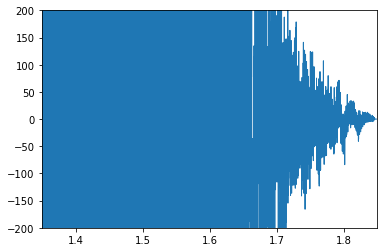

In [97]:
import matplotlib.pyplot as plt
plt.plot(np.arange(_89.shape[1])/hrir_samplingrate, _89[0,:], lw=1)
# plt.plot(np.arange(data_new.shape[0])/hrir_samplingrate, data_new, alpha=1)
plt.xlim(_89.shape[1]/hrir_samplingrate-0.500,_89.shape[1]/hrir_samplingrate)
plt.ylim(-200,200)

#### Some examples

In [ ]:
for azi, ele in [(-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180), (0,180)]:
    s = hrtf_tone(freq = 220, azi=azi, ele=ele, level=+3, show_player=True, return_signal=False)

In [ ]:

hrirs = HRIR_provider(58)

hrir_samplingrate = 44100
length = 0.5

azi = 80
ele = 0

for azi, ele in [(-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180), (0,180)]:
    if azi != 0:
        pass
    print(f"azi = {azi} | ele = {ele}")
    mono_stim = ramp(
        bandpass_mono_noise(min_freq=100, max_freq=16000, fs = hrir_samplingrate, samples=int(hrir_samplingrate*length)),
        start=0.0, stop=length-0.001, ramp_dur=0.010, fs=hrir_samplingrate, amp=1.0,
    )
    hrir_stim = np.vstack((
        np.convolve(hrirs.L[azi, ele], mono_stim),
        np.convolve(hrirs.R[azi, ele], mono_stim),
    ))
    player(hrir_stim, samplingrate=hrir_samplingrate)

In [ ]:
for subject in [21, 58, 124, 126, 134, 156]:
    hrirs = HRIR_provider(subject)
    print(hrirs.subject)
    for azi, ele in [(-40,180), (-80,0), (-40,0), (0,0), (40,0), (80,0), (40,180), (0,180)][3:4]:
        hrtf_noise(azi=azi, ele=ele, length=0.5)

## Test Page

In [ ]:
d = {}
s = noise(itd=0, min_freq=60, max_freq=6000, length=.5, pad_length=0, ramp_dur=0, show_player=False, return_signal=True)
s_null = np.zeros_like(s[0])
# Both channels
savename = f'test_sounds/noise-left-right.wav'
savepath = os.path.join(savedir, savename)
if not os.path.exists(os.path.dirname(savepath)):
    os.mkdir(os.path.dirname(savepath))
save_wave(s, savepath)
d[1] = savename
# Only LEFT channel
savename = f'test_sounds/noise-left.wav'
savepath = os.path.join(savedir, savename)
save_wave([s[0], s_null], savepath)
d[0] = savename
# Only RIGHT channel
savename = f'test_sounds/noise-right.wav'
savepath = os.path.join(savedir, savename)
save_wave([s_null, s[1]], savepath)
d[2] = savename

print('var sounds = ', json.dumps(d, indent=4), ';', sep='')